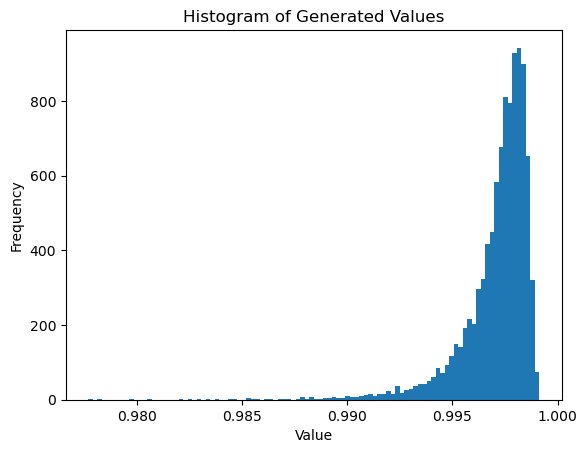

1st order moment -  True: 0.0 , GAN: [0.]
2nd order moment -  True: 1.0024087379694386 , GAN: [2.8727343e-06]
3rd order moment -  True: -0.014650595748265308 , GAN: [-1.414174e-08]
4th order moment -  True: 2.9124900473366435 , GAN: [1.4841897e-10]


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input

tf.get_logger().setLevel('ERROR')

import sys
import contextlib

@contextlib.contextmanager
def suppress_stdout():
    """Suppress output of code block."""
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

np.random.seed(1)

NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

def generate_data(n_samples=10000, n_dim=1):
    return np.random.randn(n_samples, n_dim)

def set_model(input_dim, output_dim, hidden_dim=64, n_layers=1, activation='tanh',
              optimizer='adam', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=activation))
    for _ in range(n_layers - 1):
        model.add(Dense(hidden_dim, activation=activation))
    if output_dim == 1:
        model.add(Dense(output_dim, activation='sigmoid'))
    else:
        model.add(Dense(output_dim))  # Linear activation for generator output
    model.compile(loss=loss, optimizer=optimizer)
    return model

def get_gan_network(discriminator, random_dim, generator, optimizer='adam'):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def train_gan(epochs=100, batch_size=128):
    x_train = generate_data(n_samples=12800, n_dim=DATA_DIM)
    batch_count = int(x_train.shape[0] / batch_size)

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',
                          loss='mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers=D_LAYERS, activation='tanh')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for _ in range(epochs):
        for _ in range(batch_count):
            noise = np.random.rand(batch_size, NOISE_DIM)
            true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

            with suppress_stdout():
                generated_values = generator.predict(noise, verbose=0)

            X = np.concatenate([generated_values, true_batch])
            y_dis = np.zeros(2 * batch_size)
            y_dis[batch_size:] = 0.9

            discriminator.trainable = True
            with suppress_stdout():
                discriminator.train_on_batch(X, y_dis)
            discriminator.trainable = False

            noise = np.random.rand(batch_size, NOISE_DIM)
            y_gen = np.ones(batch_size)
            with suppress_stdout():
                gan.train_on_batch(noise, y_gen)

    return generator, discriminator

generator, discriminator = train_gan()

noise = np.random.rand(10000, NOISE_DIM)
with suppress_stdout():
    generated_values = generator.predict(noise, verbose=0)
plt.hist(generated_values, bins=100)
plt.title('Histogram of Generated Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

true_gaussian = np.random.randn(10000)

print('1st order moment - ', 'True:', scipy.stats.moment(true_gaussian, 1),
      ', GAN:', scipy.stats.moment(generated_values, 1))
print('2nd order moment - ', 'True:', scipy.stats.moment(true_gaussian, 2),
      ', GAN:', scipy.stats.moment(generated_values, 2))
print('3rd order moment - ', 'True:', scipy.stats.moment(true_gaussian, 3),
      ', GAN:', scipy.stats.moment(generated_values, 3))
print('4th order moment - ', 'True:', scipy.stats.moment(true_gaussian, 4),
      ', GAN:', scipy.stats.moment(generated_values, 4))


### Trying different noise dimensions

Training GAN with noise dimension: 1
Epoch 1/10 completed for noise_dim=1


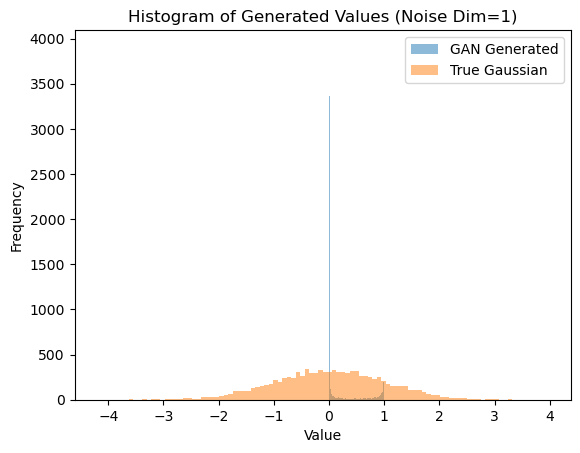

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 1.004763686506069 , GAN: 0.21898389
3rd order moment -  True: -0.053665891121976714 , GAN: -0.012366972
4th order moment -  True: 3.0480392422751 , GAN: 0.05278173


Training GAN with noise dimension: 2
Epoch 1/10 completed for noise_dim=2


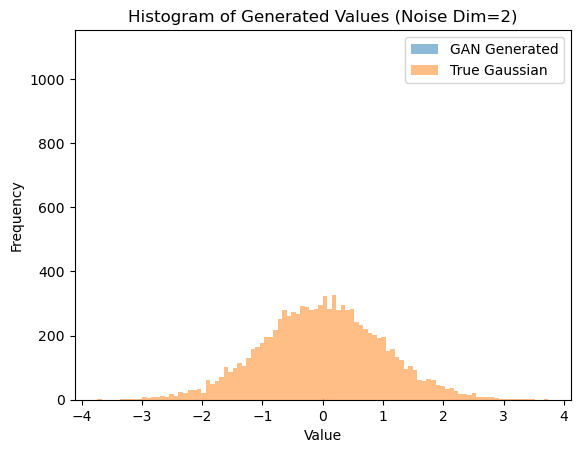

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 0.9930169207635284 , GAN: 1.1642154e-06
3rd order moment -  True: 0.004643255327335065 , GAN: 3.175503e-09
4th order moment -  True: 2.9991362855091053 , GAN: 1.7767138e-11


Training GAN with noise dimension: 5
Epoch 1/10 completed for noise_dim=5


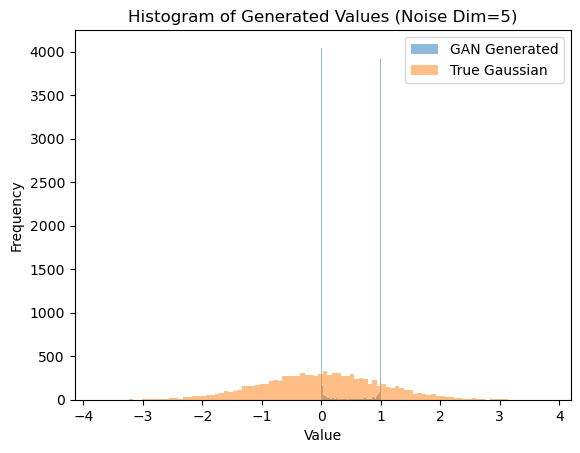

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 1.0039478296658582 , GAN: 0.22761013
3rd order moment -  True: -0.02365594465868281 , GAN: 0.002025129
4th order moment -  True: 2.9725808306949135 , GAN: 0.05506812


Training GAN with noise dimension: 10
Epoch 1/10 completed for noise_dim=10


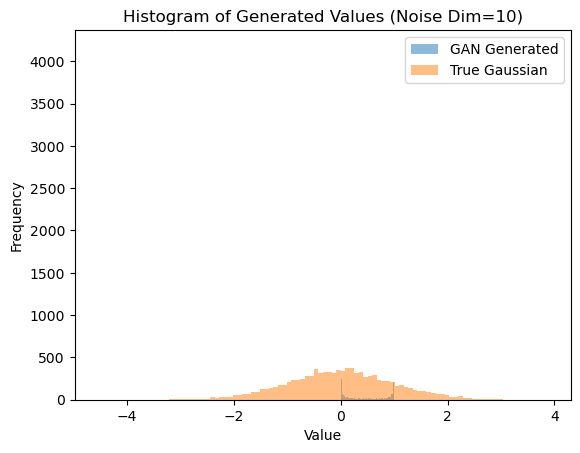

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 0.9943496460632785 , GAN: 0.22152266
3rd order moment -  True: 0.013982465733640677 , GAN: 0.018165521
4th order moment -  True: 2.996189348119677 , GAN: 0.054328404


Training GAN with noise dimension: 20
Epoch 1/10 completed for noise_dim=20


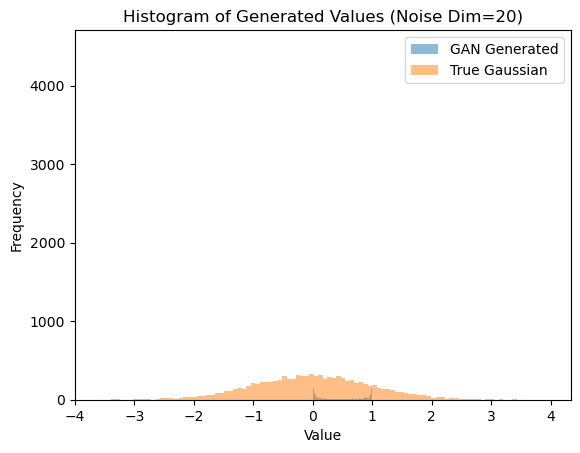

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 0.9867768939372851 , GAN: 0.22601552
3rd order moment -  True: 0.01877092559884066 , GAN: 0.020737162
4th order moment -  True: 3.001098210932355 , GAN: 0.05612777




In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input

tf.get_logger().setLevel('ERROR')

import sys
import contextlib

@contextlib.contextmanager
def suppress_stdout():
    """Suppress output of code block."""
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

np.random.seed(1)

DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

def generate_data(n_samples=10000, n_dim=1):
    return np.random.randn(n_samples, n_dim)

def set_model(input_dim, output_dim, hidden_dim=64, n_layers=1, activation='tanh',
              optimizer='adam', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=activation))
    for _ in range(n_layers - 1):
        model.add(Dense(hidden_dim, activation=activation))
    if output_dim == 1:
        model.add(Dense(output_dim, activation='sigmoid'))
    else:
        model.add(Dense(output_dim))  # Linear activation for generator output
    model.compile(loss=loss, optimizer=optimizer)
    return model

def get_gan_network(discriminator, random_dim, generator, optimizer='adam'):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def train_gan(noise_dim=10, epochs=100, batch_size=128):
    x_train = generate_data(n_samples=12800, n_dim=DATA_DIM)
    batch_count = int(x_train.shape[0] / batch_size)

    generator = set_model(noise_dim, DATA_DIM, n_layers=G_LAYERS, activation='tanh',
                          loss='mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers=D_LAYERS, activation='tanh')
    gan = get_gan_network(discriminator, noise_dim, generator, 'adam')

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.randn(batch_size, noise_dim)  # Use standard normal noise
            true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

            with suppress_stdout():
                generated_values = generator.predict(noise, verbose=0)

            X = np.concatenate([generated_values, true_batch])
            y_dis = np.zeros(2 * batch_size)
            y_dis[batch_size:] = 0.9  # Label smoothing for real samples

            discriminator.trainable = True
            with suppress_stdout():
                discriminator.train_on_batch(X, y_dis)
            discriminator.trainable = False

            noise = np.random.randn(batch_size, noise_dim)
            y_gen = np.ones(batch_size)
            with suppress_stdout():
                gan.train_on_batch(noise, y_gen)
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} completed for noise_dim={noise_dim}")

    return generator

def evaluate_gan(generator, noise_dim, bins=100):
    noise = np.random.randn(10000, noise_dim)
    with suppress_stdout():
        generated_values = generator.predict(noise, verbose=0)
    generated_values = generated_values.flatten()

    plt.hist(generated_values, bins=bins, alpha=0.5, label='GAN Generated')
    true_gaussian = np.random.randn(10000)
    plt.hist(true_gaussian, bins=bins, alpha=0.5, label='True Gaussian')
    plt.title(f'Histogram of Generated Values (Noise Dim={noise_dim})')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print('1st order moment - ', 'True:', scipy.stats.moment(true_gaussian, 1),
          ', GAN:', scipy.stats.moment(generated_values, 1))
    print('2nd order moment - ', 'True:', scipy.stats.moment(true_gaussian, 2),
          ', GAN:', scipy.stats.moment(generated_values, 2))
    print('3rd order moment - ', 'True:', scipy.stats.moment(true_gaussian, 3),
          ', GAN:', scipy.stats.moment(generated_values, 3))
    print('4th order moment - ', 'True:', scipy.stats.moment(true_gaussian, 4),
          ', GAN:', scipy.stats.moment(generated_values, 4))
    print("\n" + "="*50 + "\n")

noise_dimensions = [1, 2, 5, 10, 20]
for nd in noise_dimensions:
    print(f"Training GAN with noise dimension: {nd}")
    generator_model = train_gan(noise_dim=nd, epochs=10, batch_size=128)
    evaluate_gan(generator_model, noise_dim=nd)


### Noise dimension 2 provide best fit for our Gaussian distribution

### Using Gaussian Mixture instead of simple Gaussian

Training GAN on Gaussian Mixture Model (GMM)
Epoch 1/100 completed for GMM with noise_dim=10
Epoch 20/100 completed for GMM with noise_dim=10
Epoch 40/100 completed for GMM with noise_dim=10
Epoch 60/100 completed for GMM with noise_dim=10
Epoch 80/100 completed for GMM with noise_dim=10
Epoch 100/100 completed for GMM with noise_dim=10


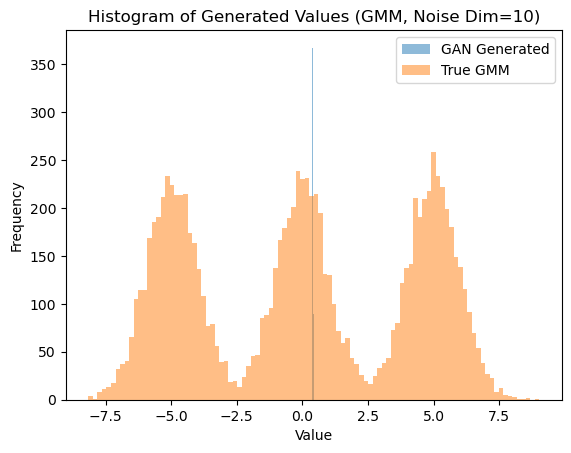

1st order moment -  True: 0.0 , GAN: 0.0
2nd order moment -  True: 17.652625033960224 , GAN: 0.00023191111
3rd order moment -  True: -0.3235903524076537 , GAN: 2.9884827e-06
4th order moment -  True: 517.6852435057676 , GAN: 1.6698482e-07




In [3]:
from sklearn.mixture import GaussianMixture

def generate_gmm_data(n_samples=10000, n_dim=1, n_components=3):
    """
    Generate data from a Gaussian Mixture Model.
    
    Parameters:
    - n_samples: Number of samples to generate.
    - n_dim: Dimensionality of the data.
    - n_components: Number of Gaussian components.
    
    Returns:
    - data: Generated data as a NumPy array.
    """
    gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=1)
    # Define means and covariances for the GMM
    means = np.linspace(-5, 5, n_components).reshape(-1, 1)
    covariances = np.array([[[1.0]] for _ in range(n_components)])
    gm.means_ = means
    gm.covariances_ = covariances
    gm.weights_ = np.ones(n_components) / n_components
    gm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gm.covariances_))
    
    data, _ = gm.sample(n_samples)
    return data

def train_gan_on_gmm(noise_dim=10, epochs=100, batch_size=128, n_components=3):
    x_train = generate_gmm_data(n_samples=12800, n_dim=DATA_DIM, n_components=n_components)
    batch_count = int(x_train.shape[0] / batch_size)

    generator = set_model(noise_dim, DATA_DIM, n_layers=G_LAYERS, activation='tanh',
                          loss='mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers=D_LAYERS, activation='tanh')
    gan = get_gan_network(discriminator, noise_dim, generator, 'adam')

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.randn(batch_size, noise_dim)
            true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

            with suppress_stdout():
                generated_values = generator.predict(noise, verbose=0)

            X = np.concatenate([generated_values, true_batch])
            y_dis = np.zeros(2 * batch_size)
            y_dis[batch_size:] = 0.9  # Label smoothing

            discriminator.trainable = True
            with suppress_stdout():
                discriminator.train_on_batch(X, y_dis)
            discriminator.trainable = False

            noise = np.random.randn(batch_size, noise_dim)
            y_gen = np.ones(batch_size)
            with suppress_stdout():
                gan.train_on_batch(noise, y_gen)
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} completed for GMM with noise_dim={noise_dim}")

    return generator

def evaluate_gan_gmm(generator, noise_dim, n_components=3, bins=100):
    noise = np.random.randn(10000, noise_dim)
    with suppress_stdout():
        generated_values = generator.predict(noise, verbose=0)
    generated_values = generated_values.flatten()

    # Generate true GMM data for comparison
    true_gmm = generate_gmm_data(n_samples=10000, n_dim=DATA_DIM, n_components=n_components).flatten()

    plt.hist(generated_values, bins=bins, alpha=0.5, label='GAN Generated')
    plt.hist(true_gmm, bins=bins, alpha=0.5, label='True GMM')
    plt.title(f'Histogram of Generated Values (GMM, Noise Dim={noise_dim})')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print('1st order moment - ', 'True:', scipy.stats.moment(true_gmm, 1),
          ', GAN:', scipy.stats.moment(generated_values, 1))
    print('2nd order moment - ', 'True:', scipy.stats.moment(true_gmm, 2),
          ', GAN:', scipy.stats.moment(generated_values, 2))
    print('3rd order moment - ', 'True:', scipy.stats.moment(true_gmm, 3),
          ', GAN:', scipy.stats.moment(generated_values, 3))
    print('4th order moment - ', 'True:', scipy.stats.moment(true_gmm, 4),
          ', GAN:', scipy.stats.moment(generated_values, 4))
    print("\n" + "="*50 + "\n")

# Train and evaluate GAN on GMM
print("Training GAN on Gaussian Mixture Model (GMM)")
generator_gmm = train_gan_on_gmm(noise_dim=10, epochs=100, batch_size=128, n_components=3)
evaluate_gan_gmm(generator_gmm, noise_dim=10, n_components=3)

### Gan is able to learn well simple Gaussian distribution, but finds hard to learn multiomodal nature of Gaussian mixture model